# CS5830 Project 8: Decision Trees/Neural Networks

In [1]:
from pathlib import Path
output_dir = Path('output')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from IPython.display import SVG
from graphviz import Source
import networkx as nx
import colorsys

In [2]:
df = pd.read_csv("diabetes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


## Explore feature correlations

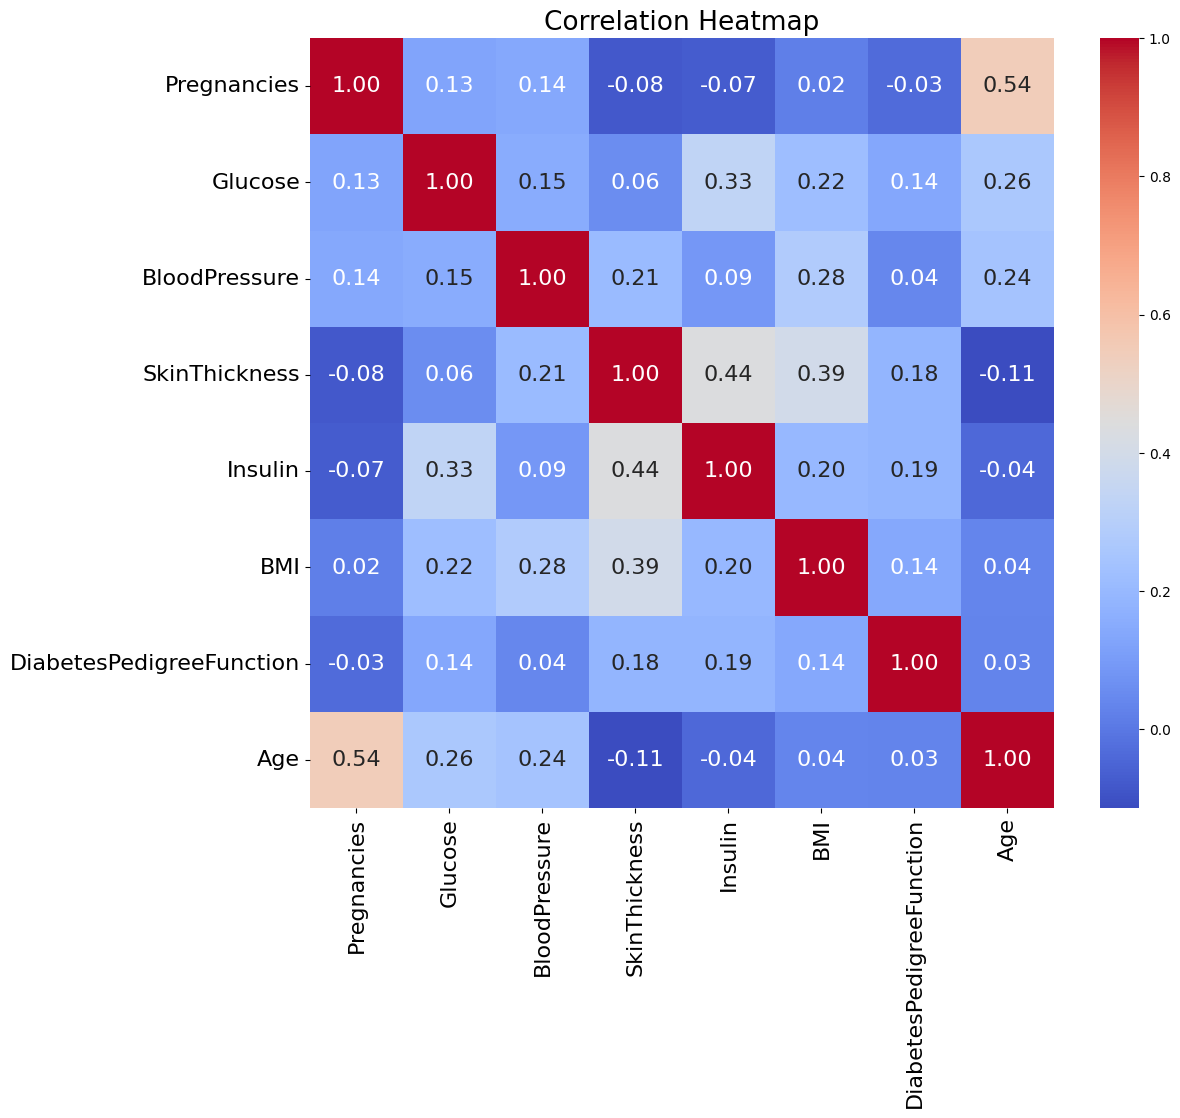

In [4]:
corr = X.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"fontsize": 16}
)  # Adjust fontsize as needed

heatmap.set_xticklabels(heatmap.get_xticklabels(),  fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)
plt.title("Correlation Heatmap", fontsize=19)  # Adjust fontsize as needed
plt.show()

In [5]:
X = X[["Glucose", "BMI", "Age", "Pregnancies", "DiabetesPedigreeFunction"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train)

,Glucose,BMI,Age,Pregnancies,DiabetesPedigreeFunction
60,84,0.0,21,2,0.304
618,112,28.2,50,9,1.282
346,139,28.7,22,1,0.654
294,161,21.9,65,0,0.254
231,134,46.2,46,6,0.238
...,...,...,...,...,...
71,139,28.6,26,5,0.411
106,96,22.4,27,1,0.207
270,101,45.6,38,10,1.136
435,141,42.4,29,0,0.205


## Decision Tree: `max_depth=3`

,Class 0,Class 1
Precision,0.798077,0.680000
Recall,0.838384,0.618182
F1,0.817734,0.647619


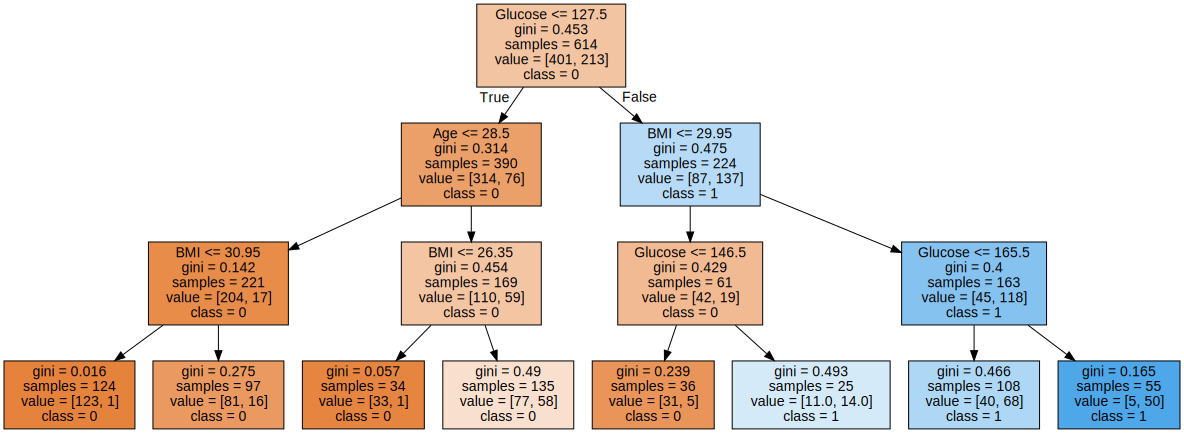

In [6]:
dt = DecisionTreeClassifier(max_depth=3, random_state=1)
dt.fit(X_train, y_train)

p, r, f, _ = precision_recall_fscore_support(y_test, dt.predict(X_test), labels=[0, 1])
display(pd.DataFrame({
    "Precision": p,
    "Recall": r,
    "F1": f
    }, index=["Class 0", "Class 1"]).T)

dot = export_graphviz(
    dt,
    out_file=None,
    feature_names=["Glucose", "BMI", "Age", "Pregnancies", "DiabetesPedigreeFunction"],
    class_names=["0", "1"],
    filled = True
)

graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
# plt.savefig("tree3.jpg")
display(svg)
svg_bytes = graph.pipe(format='png')

filename = "decision_tree3.png"
with open(output_dir / filename, "wb") as f:
    f.write(svg_bytes)

## Decision Tree: `max_depth=9`

,Class 0,Class 1
Precision,0.831579,0.661017
Recall,0.797980,0.709091
F1,0.814433,0.684211


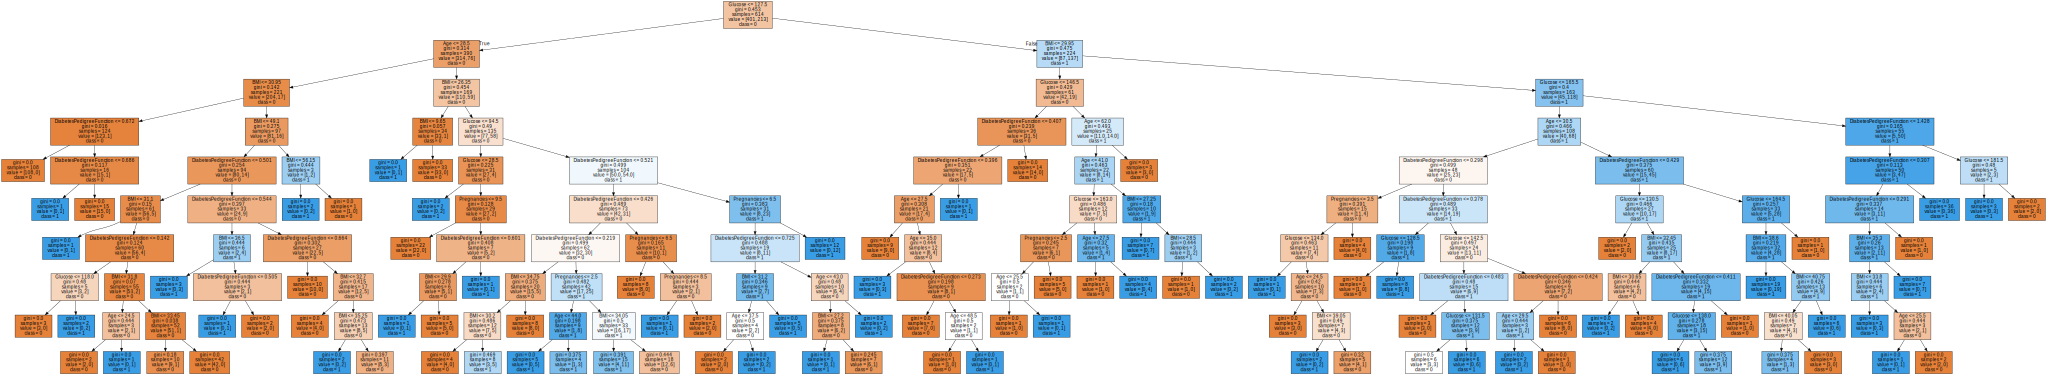

In [7]:
dt = DecisionTreeClassifier(max_depth=9, random_state=1)
dt.fit(X_train, y_train)

p, r, f, _ = precision_recall_fscore_support(y_test, dt.predict(X_test), labels=[0, 1])
display(pd.DataFrame({
    "Precision": p,
    "Recall": r,
    "F1": f
    }, index=["Class 0", "Class 1"]).T)

dot = export_graphviz(
    dt,
    out_file=None,
    feature_names=["Glucose", "BMI", "Age", "Pregnancies", "DiabetesPedigreeFunction"],
    class_names=["0", "1"],
    filled = True
)

graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)
svg_bytes = graph.pipe(format='png')

# Write the SVG bytes to a file
filename = "decision_tree5.png"
with open(output_dir / filename, "wb") as f:
    f.write(svg_bytes)

## Neural Networks

In [8]:
# Function defs

def mlp_info(mlp: MLPClassifier):
    print('This dataset has {} input nodes and {} output node(s)'.format(len(X.columns), len(y.unique())))
    print('There are {} 2D arrays of coefficients, one for each layer'.format(len(mlp.coefs_)))
    print('The layers have the following number of coefficients: {}')
    for l in range(len(mlp.coefs_)):
        m = len(mlp.coefs_[l])
        n = len(mlp.coefs_[l][0])
        print('  {}: {}x{} ({} nodes feeding into a layer of {} nodes)'.format(l, m, n, m, n))
    # Print the actual coefficients
    # print(mlp.coefs_)

    print()
    print('There are {} 1D arrays of intercepts, one for each layer'.format(len(mlp.intercepts_)))
    print('Each layer has {} intercepts, one for each node'.format([len(mlp.intercepts_[l]) for l,_ in enumerate(mlp.intercepts_)]))


def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(
        G,
        pos,
        node_color="y",
        node_size=250,
        width=weights,
        edge_color=colors
    )
    

### Scale the feature data

In [9]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,-0.526397,-1.151398,-3.752683,-1.322774,-0.701206,-4.135256,-0.490735,-1.035940
618,1.588046,-0.276643,0.680345,0.233505,-0.701206,-0.489169,2.415030,1.487101
346,-0.828460,0.566871,-1.265862,-0.090720,0.013448,-0.424522,0.549161,-0.948939
294,-1.130523,1.254179,-1.049617,-1.322774,-0.701206,-1.303720,-0.639291,2.792122
231,0.681856,0.410665,0.572222,1.076490,2.484601,1.838121,-0.686829,1.139095
...,...,...,...,...,...,...,...,...
71,0.379793,0.566871,-0.292759,0.946800,0.504235,-0.437451,-0.172824,-0.600933
106,-0.828460,-0.776503,2.842797,-1.322774,-0.701206,-1.239073,-0.778934,-0.513932
270,1.890109,-0.620297,0.896590,1.076490,-0.701206,1.760544,1.981245,0.443084
435,-1.130523,0.629354,-3.752683,-1.322774,-0.701206,1.346804,-0.784877,-0.339929


### Train and fit

#### `hidden_layer_sizes=(10, 10)`

In [10]:
mlp = MLPClassifier(
    max_iter=500,
    hidden_layer_sizes=(10, 10),
    random_state=1,
)

mlp.fit(X_train,y_train)

/home/absity/school/sp24/data/projects/project8/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500, random_state=1)

#### Prediction/Evaluation

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



Text(50.722222222222214, 0.5, 'Actual')

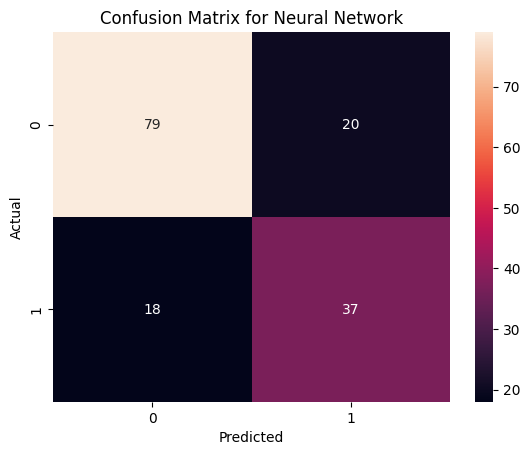

In [11]:
y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")

This dataset has 8 input nodes and 2 output node(s)
There are 3 2D arrays of coefficients, one for each layer
The layers have the following number of coefficients: {}
  0: 8x10 (8 nodes feeding into a layer of 10 nodes)
  1: 10x10 (10 nodes feeding into a layer of 10 nodes)
  2: 10x1 (10 nodes feeding into a layer of 1 nodes)

There are 3 1D arrays of intercepts, one for each layer
Each layer has [10, 10, 1] intercepts, one for each node


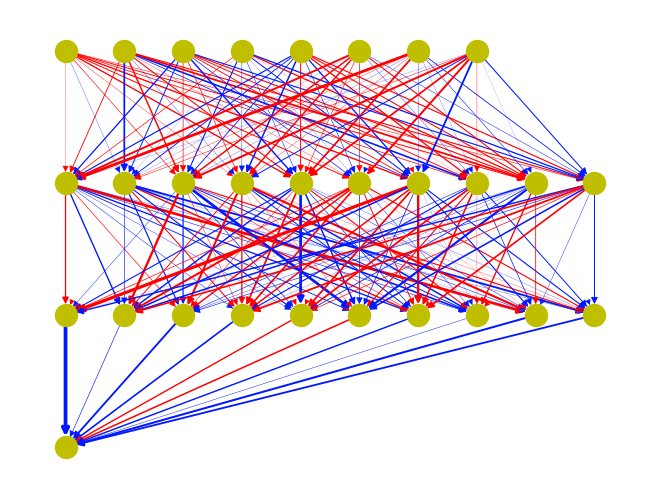

In [12]:
mlp_info(mlp)
show_ann(mlp)

#### `hidden_layer_sizes=(5, 10, 7)`

In [13]:
mlp = MLPClassifier(
    max_iter=500,
    hidden_layer_sizes=(5, 10, 7),
    random_state=1,
)

mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(5, 10, 7), max_iter=500, random_state=1)

#### Prediction/Evaluation

              precision    recall  f1-score   support

           0       0.80      0.79      0.79        99
           1       0.62      0.64      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



Text(50.722222222222214, 0.5, 'Actual')

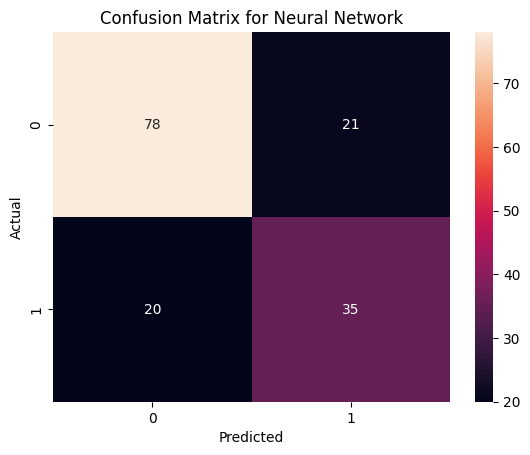

In [14]:
y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")

This dataset has 8 input nodes and 2 output node(s)
There are 4 2D arrays of coefficients, one for each layer
The layers have the following number of coefficients: {}
  0: 8x5 (8 nodes feeding into a layer of 5 nodes)
  1: 5x10 (5 nodes feeding into a layer of 10 nodes)
  2: 10x7 (10 nodes feeding into a layer of 7 nodes)
  3: 7x1 (7 nodes feeding into a layer of 1 nodes)

There are 4 1D arrays of intercepts, one for each layer
Each layer has [5, 10, 7, 1] intercepts, one for each node


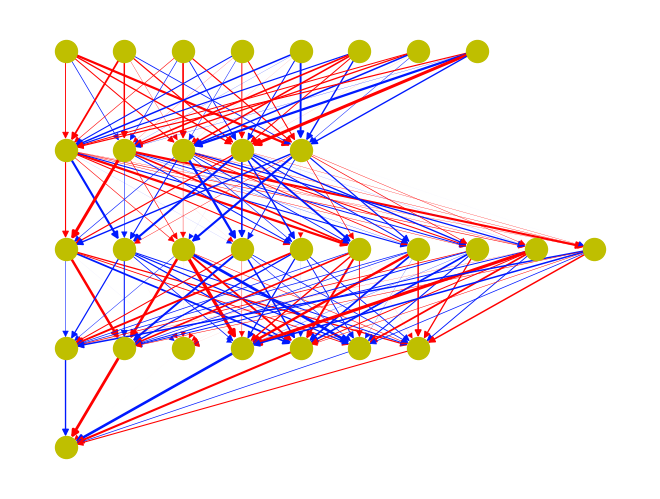

In [15]:
mlp_info(mlp)
show_ann(mlp)

#### `hidden_layer_sizes=(15)`

In [16]:
mlp = MLPClassifier(
    max_iter=500,
    hidden_layer_sizes=(15),
    random_state=1,
)

mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=15, max_iter=500, random_state=1)

#### Prediction/Evaluation

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        99
           1       0.64      0.62      0.63        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



Text(50.722222222222214, 0.5, 'Actual')

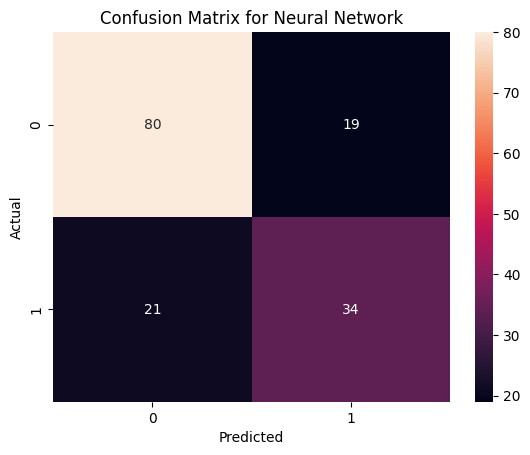

In [17]:
y_pred = mlp.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")

This dataset has 8 input nodes and 2 output node(s)
There are 2 2D arrays of coefficients, one for each layer
The layers have the following number of coefficients: {}
  0: 8x15 (8 nodes feeding into a layer of 15 nodes)
  1: 15x1 (15 nodes feeding into a layer of 1 nodes)

There are 2 1D arrays of intercepts, one for each layer
Each layer has [15, 1] intercepts, one for each node


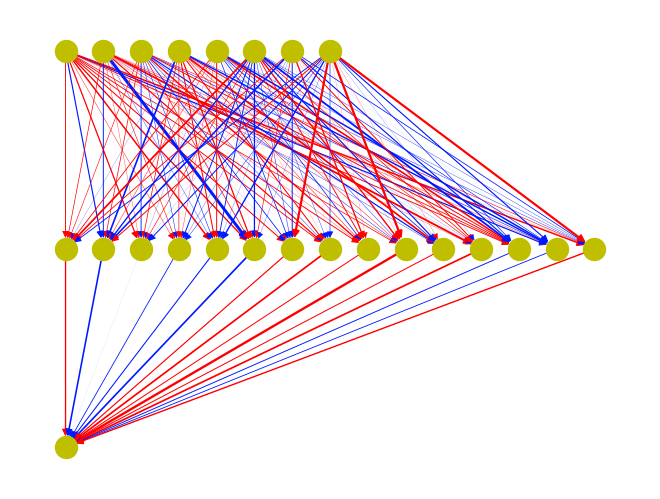

In [18]:
mlp_info(mlp)
show_ann(mlp)